## Stateful Basic Model Feedback Metrics 

![](img/diagram.jpg)

### Setup dependencies
* Istio
* Seldon Core (with Istio + Req Logger)
* Elasticsearch
* Knative eventing
* Request logger
* Model with request logger

#### Istio

In [4]:
!istioctl install -y

Detected that your cluster does not support third party JWT authentication. Falling back to less secure first party JWT. See https://istio.io/docs/ops/best-practices/security/#configure-third-party-service-account-tokens for details.
✔ Istio core installed                                                          
✔ Istiod installed                                                              
✔ Addons installed                                                              
✔ Ingress gateways installed                                                    
✔ Installation complete                                                         

In [3]:
%%bash
kubectl apply -n istio-system -f - << END
apiVersion: networking.istio.io/v1alpha3
kind: Gateway
metadata:
  name: seldon-gateway
spec:
  selector:
    istio: ingressgateway # use istio default controller
  servers:
  - port:
      number: 80
      name: http
      protocol: HTTP
    hosts:
    - "*"
END

gateway.networking.istio.io/seldon-gateway created


#### Seldon Core

In [36]:
%%bash
kubectl create ns seldon-system || echo "seldon-system ns exists"

helm upgrade --install seldon-core ../../../helm-charts/seldon-core-operator/ \
    --namespace seldon-system \
    --set certmanager.enabled="true" \
    --set istio.enabled="true" \
    --set istio.gateway="seldon-gateway.istio-system.svc.cluster.local" \
    --set executor.requestLogger.defaultEndpoint="http://default-broker.seldon-logs.svc.cluster.local"

seldon-system ns exists
Release "seldon-core" does not exist. Installing it now.
NAME: seldon-core
LAST DEPLOYED: Sat Jul 11 09:24:28 2020
NAMESPACE: seldon-system
STATUS: deployed
REVISION: 1
TEST SUITE: None


Error from server (AlreadyExists): namespaces "seldon-system" already exists


In [7]:
%%bash
kubectl create ns seldon-logs || echo "seldon-logs ns exists"
helm upgrade --install elasticsearch elasticsearch \
    --version 7.6.0 \
    --namespace=seldon-logs \
    --set service.type=LoadBalancer \
    --set antiAffinity="soft" \
    --repo https://helm.elastic.co \
    --set image=docker.elastic.co/elasticsearch/elasticsearch-oss

namespace/seldon-logs created
Release "elasticsearch" does not exist. Installing it now.
NAME: elasticsearch
LAST DEPLOYED: Sat Jul 11 08:56:31 2020
NAMESPACE: seldon-logs
STATUS: deployed
REVISION: 1
NOTES:
1. Watch all cluster members come up.
  $ kubectl get pods --namespace=seldon-logs -l app=elasticsearch-master -w
2. Test cluster health using Helm test.
  $ helm test elasticsearch


In [9]:
!kubectl rollout status statefulset/elasticsearch-master -n seldon-logs

Waiting for 3 pods to be ready...
Waiting for 2 pods to be ready...
Waiting for 1 pods to be ready...
statefulset rolling update complete 3 pods at revision elasticsearch-master-695c796997...


#### Knative Eventing

In [29]:
%%bash

kubectl apply --selector knative.dev/crd-install=true \
	--filename https://github.com/knative/eventing/releases/download/v0.11.0/eventing.yaml

kubectl apply --selector knative.dev/crd-install=true \
	--filename https://github.com/knative/eventing/releases/download/v0.11.0/eventing.yaml 

kubectl apply \
	--filename https://github.com/knative/eventing/releases/download/v0.11.0/eventing.yaml 

kubectl rollout status -n knative-eventing deployment/eventing-controller

kubectl apply --filename https://github.com/knative/eventing/releases/download/v0.11.0/in-memory-channel.yaml

customresourcedefinition.apiextensions.k8s.io/apiserversources.sources.eventing.knative.dev created
customresourcedefinition.apiextensions.k8s.io/brokers.eventing.knative.dev created
customresourcedefinition.apiextensions.k8s.io/channels.messaging.knative.dev created
customresourcedefinition.apiextensions.k8s.io/containersources.sources.eventing.knative.dev created
customresourcedefinition.apiextensions.k8s.io/cronjobsources.sources.eventing.knative.dev created
customresourcedefinition.apiextensions.k8s.io/eventtypes.eventing.knative.dev created
customresourcedefinition.apiextensions.k8s.io/parallels.flows.knative.dev created
customresourcedefinition.apiextensions.k8s.io/sequences.flows.knative.dev created
customresourcedefinition.apiextensions.k8s.io/parallels.messaging.knative.dev created
customresourcedefinition.apiextensions.k8s.io/sequences.messaging.knative.dev created
customresourcedefinition.apiextensions.k8s.io/sinkbindings.sources.eventing.knative.dev created
customresourcede

In [23]:
!kubectl get pods -n knative-eventing

NAME                                  READY   STATUS    RESTARTS   AGE
eventing-controller-d67878576-szkqx   1/1     Running   0          34s
eventing-webhook-5b45945585-l8xxf     1/1     Running   0          34s
imc-controller-67b4c9787b-np5cm       1/1     Running   0          30s
imc-dispatcher-7b57bc9796-b4hpn       1/1     Running   0          30s
sources-controller-685db898c-t65fl    1/1     Running   0          34s


#### Create Request Logger in Seldon Logs namespace

In [31]:
!kubectl label namespace seldon-logs knative-eventing-injection=enabled --overwrite=true

namespace/seldon-logs labeled


In [32]:
!kubectl get broker -n seldon-logs 

NAME      READY   REASON   URL                                                   AGE
default   True             http://default-broker.seldon-logs.svc.cluster.local   18s


In [30]:
%%bash
kubectl apply -f - << END
apiVersion: eventing.knative.dev/v1alpha1
kind: Trigger
metadata:
 name: seldon-request-logger-trigger
 namespace: seldon-logs
spec:
 subscriber:
   ref:
     apiVersion: v1
     kind: Service
     name: seldon-request-logger
END

kubectl apply -f - << END
apiVersion: apps/v1
kind: Deployment
metadata:
 name: seldon-request-logger
 namespace: seldon-logs
 labels:
   app: seldon-request-logger
spec:
 replicas: 1
 selector:
   matchLabels:
     app: seldon-request-logger
 template:
   metadata:
     labels:
       app: seldon-request-logger
   spec:
     containers:
       - name: user-container
         image: docker.io/seldonio/seldon-request-logger:1.2.2-dev
         imagePullPolicy: IfNotPresent
         env:
           - name: ELASTICSEARCH_HOST
             value: "elasticsearch-master.seldon-logs.svc.cluster.local"
           - name: ELASTICSEARCH_PORT
             value: "9200"
END

kubectl apply -f - << END
apiVersion: v1
kind: Service
metadata:
 name: seldon-request-logger
 namespace: seldon-logs
spec:
 selector:
   app: seldon-request-logger
 ports:
   - protocol: TCP
     port: 80
     targetPort: 8080
END

trigger.eventing.knative.dev/seldon-request-logger-trigger created
deployment.apps/seldon-request-logger unchanged
service/seldon-request-logger unchanged


In [33]:
!kubectl get trigger -n seldon-logs

NAME                            READY   REASON   BROKER    SUBSCRIBER_URI                                                AGE
seldon-request-logger-trigger   True             default   http://seldon-request-logger.seldon-logs.svc.cluster.local/   2m18s


In [ ]:
#### Deploy model with request logger

In [54]:
%%bash

kubectl create ns seldon || echo "seldon ns exists"

kubectl apply -n seldon -f - << END
kind: SeldonDeployment
apiVersion: machinelearning.seldon.io/v1
metadata:
  name: sklearn
spec:
  annotations:
    seldon.io/engine-seldon-log-messages-externally: 'true'
  name: sklearn
  predictors:
  - name: default
    graph:
      name: irisclassifier-default
      implementation: SKLEARN_SERVER
      endpoint:
        type: REST
      modelUri: gs://seldon-models/sklearn/iris
      logger:
        mode: "all"
    replicas: 1
END

seldon ns exists
seldondeployment.machinelearning.seldon.io/sklearn configured


Error from server (AlreadyExists): namespaces "seldon" already exists


## Send Request

In [ ]:
import requests
url = "http://localhost:80/seldon/seldon/sklearn/api/v1.0"

In [55]:
pred_req_1 = {"data":{"ndarray":[[1,2,3,4]]}}
pred_resp_1 = requests.post(f"{url}/predictions", json=pred_req_1)

In [56]:
print(f"Response ID: {pred_resp_1.headers.get('seldon-puid')}")
print(pred_resp_1.json())

Response ID: b470c0a1-e207-43d4-90d4-db64b879d068
{'data': {'names': ['t:0', 't:1', 't:2'], 'ndarray': [[0.0006985194531162841, 0.003668039039435755, 0.9956334415074478]]}, 'meta': {}}


### Check request was sent to Elasticsearch

In [57]:
from elasticsearch import Elasticsearch
es = Elasticsearch(['http://localhost:9200'])

See the index that has been created

In [58]:
 es.indices.get_alias("*")

{'inference-log-seldon-seldon-sklearn-default': {'aliases': {}}}

Check that the index has been created for that request

In [75]:
res = es.search(index="inference-log-seldon-seldon-sklearn-default", body={"query": {"match_all": {}}})
print("Logged Request:")
print(res["hits"]["hits"][0]["_source"]["request"])
print("\nLogged Response:")
print(res["hits"]["hits"][0]["_source"]["response"])

Logged Request:
{'ce-source': 'http:localhost:8000', 'instance': [1.0, 2.0, 3.0, 4.0], 'payload': {'data': {'ndarray': [[1, 2, 3, 4]]}}, 'dataType': 'tabular', 'elements': {}, 'ce-time': '2020-07-11T08:41:50.378621945Z'}

Logged Response:
{'payload': {'data': {'names': ['t:0', 't:1', 't:2'], 'ndarray': [[0.0006985194531162841, 0.003668039039435755, 0.9956334415074478]]}, 'meta': {}}, 'dataType': 'tabular', 'elements': {'t:0': [0.0006985194531162841], 't:1': [0.003668039039435755], 't:2': [0.9956334415074478]}, 'instance': [0.0006985194531162841, 0.003668039039435755, 0.9956334415074478], 'names': ['t:0', 't:1', 't:2'], 'ce-time': '2020-07-11T08:41:50.384083245Z', 'ce-source': 'http:localhost:8000'}


### Now we can send feedback 

For this we can include the reward, which in this case can state whether it's correct or incorrect, together with the truth answer, in case it was incorrect (or to emphasise that it was correct).

In order for us to be able to send the feedback to the right request, we need to provide the feedback ID for the request:

In [79]:
puid_seldon_1 = pred_resp_1.headers.get("seldon-puid")

print(puid_seldon_1)

b470c0a1-e207-43d4-90d4-db64b879d068


We will also be able to add extra metadata, such as the user providing the feedback, date, time, etc.

In [82]:
feedback_tags_1 = {
    "user": "Seldon Admin",
    "date": "11/07/2020"
}

And finally we can put together the feedback request.

In [84]:
feedback_req_1 = {
    "reward": 0,
    "truth": {
        'data': {
            'names': ['t:0', 't:1', 't:2'], 
            'ndarray': [[0, 0, 1]]
        },
        "meta": {
            "tags": feedback_tags_1
        }
    }
}

In [85]:
feedback_resp_1 = requests.post(f"{url}/feedback", json=feedback_req_1, headers={"seldon-puid": puid_seldon_1})

In [86]:
feedback_resp_1

<Response [200]>

### CHeck that feedback has been received

In [87]:
res = es.search(index="inference-log-seldon-seldon-sklearn-default", body={"query": {"match_all": {}}})
print(res["hits"]["hits"][0]["_source"]["feedback"])

{'reward': 0, 'ce-source': 'http:localhost:8000', 'truth': {'data': {'names': ['t:0', 't:1', 't:2'], 'ndarray': [[0.0006985194531162841, 0.003668039039435755, 0.9956334415074478]]}, 'meta': {'tags': {'date': '11/07/2020', 'user': 'Seldon Admin'}}}, 'ce-time': '2020-07-11T09:00:44.310299646Z'}


### Stateful metrics Overview

Now that we have seen the basics of the feedback mechanism we can actually leverage the features it provides.

For this we'll want to send a few requests, together with feedback to some requests. This will include:
* 100 requests in total
* 50 will be provided feedback
* 35 of those will be correct (the rest incorrect)

Once we set up the requests, we will be able to get further insights.

In [248]:
TOTAL_REQS = 100
MAX_FEEDBACK = 63
MAX_CORRECT = 46

In [249]:
es.indices.delete(index='inference-log-seldon-seldon-sklearn-default', ignore=[400, 404])

{'acknowledged': True}

#### First send all the requests

In [250]:
ids_list = []
for i in range(TOTAL_REQS):
    pred_req = {"data":{"ndarray":[[1,2,3,4]]}}
    pred_resp = requests.post(f"{url}/predictions", json=pred_req)
    assert pred_resp.status_code == 200
    ids_list.append(pred_resp.headers["seldon-puid"])
    

In [258]:
es_count = es.count(index="inference-log-seldon-seldon-sklearn-default")
print(es_count)

{'count': 100, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}


#### Then send the feedback

In [259]:
default_truth_val = {'data': { 'names': ['t:0', 't:1', 't:2'], 'ndarray': [[0, 0, 1]]}}
default_truth_meta = {"tags": {"user": "Seldon Admin", "date": "11/07/2020"}}

for idx, sid in enumerate(ids_list):
    if idx == MAX_FEEDBACK: break # we only want to provide feedback to 50
    
    feedback = {}
    feedback["reward"] = idx < MAX_CORRECT
    feedback["truth"] = {} if idx < MAX_CORRECT else default_truth_val
    feedback["truth"]["meta"] = default_truth_meta
    
    pred_resp = requests.post(f"{url}/feedback", json=feedback, headers={"seldon-puid": sid})
    assert pred_resp.status_code == 200

### Exposing Feedback Metrics

Now that feedback has been provided, it's possible to expose the feedback metrics for visualisation.

The default and simplest way to provide this is basically through two simple metrics:
* Accuracy 
* Number of data with feedback

This can be extended to also provide insights such as:
* Precision
* Recall
* Specificity
* F1 score

Primarily as these insights can be provided as insights with teh feedback. For more advanced metrics is discussed below.

In [260]:
query = {
  "aggregations": { 
    "reward_sum": { "sum": { "field": "feedback.reward" } },
    "reward_count": { "filter": { "exists": { "field": "feedback.reward"} } }
  }
}
feedback_metrics = es.search(index="inference-log-seldon-seldon-sklearn-default", body=query)
print(feedback_metrics["aggregations"])

{'reward_sum': {'value': 46.0, 'value_as_string': 'true'}, 'reward_count': {'doc_count': 63}}


This can also be performed for a specified datetime, so you can actually filter the accuracy / performance based on:
* Date of processing of the initial request
* Date of feedback being provided

Below is a simple visualisation of these results:

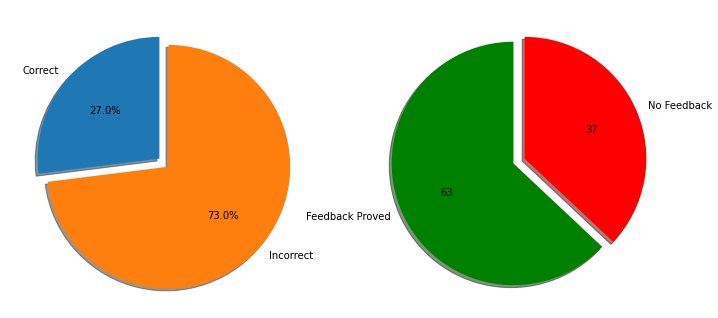

In [271]:
import numpy as np
import matplotlib.pyplot as plt

feedback_correct = feedback_metrics["aggregations"]["reward_sum"]["value"]
feedback_total = feedback_metrics["aggregations"]["reward_count"]["doc_count"]
feedback_incorrect = feedback_total - feedback_correct
no_feedback = es_count["count"] - feedback_total

plt.subplots(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie([feedback_incorrect, feedback_correct], explode=(0, 0.1), labels=('Correct', 'Incorrect'), autopct='%1.1f%%', shadow=True, startangle=90)

plt.subplot(1, 2, 2)
plt.pie([feedback_total, no_feedback], explode=(0.1, 0), labels=('Feedback Proved', 'No Feedback'), autopct='%.0f', shadow=True, startangle=90, colors=['green', 'red'])

plt.show()

### Advanced ML Insights

In the case where more advanced ML Metrics are to be computed, these can be done in two ways:
* Add stateful processing of the feedback provided
* Perform the calculation in the request logger
* Retrieve all of the datapoints from ELK and calculate the metrics

#### Add stateful processing of the feedback provided

Similar to the design pattern that Seldon Core introduced with request logging and outlier detectors through asynchronous eventing, it's possible to do the same for metrics.

More specifically, it is possible to set up a stateful feedback processor which retrieves all the metrics on start and registers for feedback events to provide real time insights on any new incoming requests.

These can then be visualised through different areas such as through prometheus metrics, using a grafana dashboard. Below is a brief example of how this can be achieved through a simple implementation.

![](img/metrics-processor.jpg)


#### Perform the calculation in the request logger

If this is to eb performed in the request logger, it's possible to build your own custom request logger.

In this, you woudl be able to add logic to retrieve the specific request from the prediction, and then calculate the performance against the specific metrics you are required. 

Finally these results can be stored back into the Elasticsearch index using an "upsert" (update + insert).

![](img/req-logger.jpg)


#### Retrieve all of the datapoints from ELK and calculate the metrics

In this second option, you would be able to fetch all of the datapoints for a specific model and perform processing on top.

This would allow you to have more flexibility, especially for calculations which would require maintaining a global metric across your data, such as for global AI explanation techniques.

The example below shows how you would be able to retrieve this data and process it. 

Given that these would often be stateful, you may want to run this in an async fashion and store it for later/efficient retrieval.

![](img/custom-aggreg.jpg)